# Random search를 이용한 hyper parameter tuning

## Setting

In [44]:
import pandas as pd
import os
import FinanceDataReader as fdr
from datetime import datetime as dt
import numpy as np
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_error

from scipy.stats import uniform

from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [53]:
param_grid = {'a':uniform(9,2)}
param_list = list(ParameterSampler(param_grid, n_iter=10))
for p in param_list:
    print(p['a'])

9.404253508111792
10.077567561548191
9.03398257167687
10.04747981005045
10.157557221534965
9.735468071346379
10.98797442341392
10.345285945495673
9.255791837212831
10.639976927608778


In [56]:
def draw_plot(company_lst, start_date='20200101', end_date='20201231'):
    stock_lst = []
    for company in company_lst:
        sample_code = stock_list[stock_list.종목명 == company].종목코드.values[0]
        data = fdr.DataReader(sample_code, start = start_date, end = end_date).Close
        data = (data - data.mean()) / data.std()
        plt.plot(data, label = company)
        
    plt.legend()
    plt.show()  

In [49]:
def NMAE(y_true, y_hat):
    #y_true, y_hat = y_true.values, y_hat.values
    return mean_absolute_error(y_true, y_hat) / np.mean(np.abs(y_true))

In [105]:
def tuning(stock_list, num, param_sample):
    count_df = stock_list.groupby('산업군').count().sort_values(by='종목명', ascending=False)['종목명'].reset_index()
    industry_lst = count_df[count_df.종목명 >= num].산업군.tolist()
    
    model_parameters = pd.DataFrame(columns = ['code',
                                               'industry',
                                               'NMAE',
                                               'changepoint_prior_scale',
                                               'changepoint_range',
                                               'fourier_order',
                                               'period'
                                               ])

    for industry in tqdm(industry_lst, position=2):
        code_list = stock_list[stock_list.산업군==industry].종목코드.tolist()

        random.seed(0)
        samples = random.sample(code_list, 5)

        for code in tqdm(samples, position=1):
            data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

            sc = StandardScaler()
            data_scaled = pd.DataFrame({'ds':data_raw.index,
                                        'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})

            train = data_scaled[data_scaled.ds <= pd.to_datetime('2021-08-06')] 
            val = data_scaled[data_scaled.ds > pd.to_datetime('2021-08-06')] 

            for p in tqdm(param_sample, position=0):
                prophet = Prophet(seasonality_mode='multiplicative', 
                                  yearly_seasonality=False,
                                  weekly_seasonality=False,
                                  daily_seasonality=False,
                                  changepoint_prior_scale=p['changepoint_prior_scale'],
                                  changepoint_range=p['changepoint_range'],
                                  )
                prophet.add_seasonality(name='seasonality_1',period=p['period'],fourier_order=p['fourier_order'])
                prophet.fit(train)

                # 21일치를 예측합니다.
                future_data = prophet.make_future_dataframe(periods=21)
                forecast_data = prophet.predict(future_data)

                pred_y = forecast_data[forecast_data.ds.map(lambda x: x in val.ds.tolist())].yhat
                pred_y = sc.inverse_transform(pred_y.values.reshape(-1,1))

                y_true = sc.inverse_transform(val.y.values.reshape(-1,1))

                error =  NMAE(y_true, pred_y) * 100
                model_parameters = model_parameters.append({'code':code,
                                                            'industry':industry,
                                                            'NMAE':error,
                                                            'changepoint_prior_scale':p['changepoint_prior_scale'],
                                                            'changepoint_range':p['changepoint_range'],
                                                            'fourier_order':p['fourier_order'],
                                                            'period':p['period'],
                                                            },ignore_index=True)

    code_list = stock_list[stock_list.산업군.map(lambda x: x not in industry_lst)].종목코드.tolist()
    random.seed(0)
    samples = random.sample(code_list, 10)

    for code in tqdm(samples, position=1):
        data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

        sc = StandardScaler()
        data_scaled = pd.DataFrame({'ds':data_raw.index,
                                    'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})

        train = data_scaled[data_scaled.ds <= pd.to_datetime('2021-08-06')] 
        val = data_scaled[data_scaled.ds > pd.to_datetime('2021-08-06')] 

        for p in tqdm(param_sample, position=0):
            prophet = Prophet(seasonality_mode='multiplicative', 
                              yearly_seasonality=False,
                              weekly_seasonality=False,
                              daily_seasonality=False,
                              changepoint_prior_scale=p['changepoint_prior_scale'],
                              changepoint_range=p['changepoint_range'],
                              )
            prophet.add_seasonality(name='seasonality_1',period=p['period'],fourier_order=p['fourier_order'])
            prophet.fit(train)

            # 21일치를 예측합니다.
            future_data = prophet.make_future_dataframe(periods=21)
            forecast_data = prophet.predict(future_data)

            pred_y = forecast_data[forecast_data.ds.map(lambda x: x in val.ds.tolist())].yhat
            pred_y = sc.inverse_transform(pred_y.values.reshape(-1,1))

            y_true = sc.inverse_transform(val.y.values.reshape(-1,1))

            error =  NMAE(y_true, pred_y) * 100
            model_parameters = model_parameters.append({'code':code,
                                                        'industry':'기타',
                                                        'NMAE':error,
                                                        'changepoint_prior_scale':p['changepoint_prior_scale'],
                                                        'changepoint_range':p['changepoint_range'],
                                                        'fourier_order':p['fourier_order'],
                                                        'period':p['period'],
                                                        },ignore_index=True)
            
    param_pivot= pd.pivot_table(data=model_parameters,
                                values='NMAE', 
                                index=['industry','changepoint_prior_scale','changepoint_range',
                                       'fourier_order','period'],
                                columns=['code']).reset_index()
    param_pivot['mean'] = np.nanmean(param_pivot.iloc[:,5:].values, axis=1)
    param_pivot = param_pivot.drop(param_pivot.columns[5:-1], axis=1).sort_values(by=['industry','mean'])
    param_pivot.index = range(len(param_pivot))
    param_pivot.columns.name = ''
    
    param_pivot['best']=0

    for i in param_pivot.industry.unique():
        min_index = param_pivot[param_pivot.industry==i].index.min()
        param_pivot.loc[min_index,'best']=1

    return model_parameters, param_pivot, industry_lst

In [51]:
def preprocess_for_merge(x, lst):
    if x not in lst:
        return '기타'
    else:
        return x

def test(stock_list, param_pivot, industry_lst):
    stock_list['industry']=stock_list.산업군
    stock_list.industry = stock_list.industry.map(lambda x: preprocess_for_merge(x,industry_lst))
    
    best_param = param_pivot[param_pivot.best==1]
    
    info_train = pd.merge(stock_list.drop(['산업군'], axis=1),
                          best_param.drop(['mean','best'], axis=1),
                          how='left',
                          on='industry')
    submission = pd.read_csv('./open_week3/sample_submission_week3.csv')
    target_day = pd.to_datetime(submission.Day).tolist()

    for _, row in tqdm(info_train.iterrows()):
        code= row['종목코드']
        data_raw = fdr.DataReader(code, start = '20210101', end = '20210829').Close

        sc = StandardScaler()
        data_scaled = pd.DataFrame({'ds':data_raw.index,
                                    'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})

        m = Prophet(seasonality_mode='multiplicative', 
                    yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False,
                    changepoint_prior_scale=row['changepoint_prior_scale'],
                    changepoint_range=row['changepoint_range']
                   )
        m.add_seasonality(name='seasonality_1',
                          period=row['period'],
                          fourier_order=row['fourier_order'])

        m.fit(data_scaled)
        future = m.make_future_dataframe(periods=7)
        forecast = m.predict(future)

        result = forecast[['ds','yhat']]
        result.yhat = sc.inverse_transform(result.yhat.values.reshape(-1,1))

        result_1 = result[result.ds.map(lambda x:x in target_day[:5])].yhat.values

        data_raw = fdr.DataReader(code, start = '20210101', end = '20210912').Close

        sc = StandardScaler()
        data_scaled = pd.DataFrame({'ds':data_raw.index,
                                    'y':sc.fit_transform(data_raw.values.reshape(-1,1)).flatten()})

        m = Prophet(seasonality_mode='multiplicative', 
                    yearly_seasonality=False,
                    weekly_seasonality=False,
                    daily_seasonality=False,
                    changepoint_prior_scale=row['changepoint_prior_scale'],
                    changepoint_range=row['changepoint_range']
                   )
        m.add_seasonality(name='seasonality_1',
                          period=row['period'],
                          fourier_order=row['fourier_order'])

        m.fit(data_scaled)
        future = m.make_future_dataframe(periods=7)
        forecast = m.predict(future)

        result = forecast[['ds','yhat']]
        result.yhat = sc.inverse_transform(result.yhat.values.reshape(-1,1))

        result_2 = result[result.ds.map(lambda x:x in target_day[5:])].yhat.values

        submission[code]=np.vstack([result_1.reshape(-1,1),result_2.reshape(-1,1)]).flatten()
        
    return submission

## Read file

In [55]:
path = './open_week3'
list_name = 'Stock_List.csv'
stock_list = pd.read_csv(os.path.join(path,list_name), encoding='CP949')
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list # 대형/중형주? 

,종목명,종목코드,상장시장,산업군
0,삼성전자,005930,KOSPI,반도체와반도체장비
1,SK하이닉스,000660,KOSPI,반도체와반도체장비
2,NAVER,035420,KOSPI,양방향미디어와서비스
3,카카오,035720,KOSPI,양방향미디어와서비스
4,삼성바이오로직스,207940,KOSPI,제약
...,...,...,...,...
371,더네이쳐홀딩스,298540,KOSDAQ,"섬유,의류,신발,호화품"
372,코엔텍,029960,KOSDAQ,상업서비스와공급품
373,원익홀딩스,030530,KOSDAQ,반도체와반도체장비
374,웹케시,053580,KOSDAQ,소프트웨어


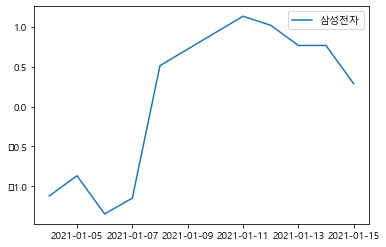

In [59]:
draw_plot(['삼성전자'], '20210104','20210115')

## Tuning With Random Search

In [102]:
params_grid = {'changepoint_prior_scale':uniform(0.03, 0.09),
               'changepoint_range' : uniform(0.5,0.4),
               'fourier_order' : range(5,11),
               'period':uniform(0.1,0.9)
               }
params_sample = ParameterSampler(params_grid, n_iter=60, random_state=0)
rounded_params = [dict((k, round(v, 6)) for (k, v) in d.items()) for d in params_sample]

In [103]:
len(rounded_params)

60

In [106]:
model_parameters, param_pivot, industry_lst = tuning(stock_list, 10, rounded_params)



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:05<00:00,  1.10s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:08<00:00,  1.14s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:05<00:00,  1.09s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:04<00:00,  1.08s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:04<00:00,  1.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:29<00:00, 65.86s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:04<00:00,  1.08s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [01:13<00:00,  1.22s/it]

100%|████████████████████████

In [111]:
param_pivot

,industry,changepoint_prior_scale,changepoint_range,fourier_order,period,mean,best
0,게임엔터테인먼트,0.072312,0.786430,5,0.445116,7.637804,1
1,게임엔터테인먼트,0.056047,0.573277,7,0.597539,7.815130,0
2,게임엔터테인먼트,0.073905,0.852402,9,0.439977,8.406448,0
3,게임엔터테인먼트,0.054301,0.794078,10,0.489959,8.458214,0
4,게임엔터테인먼트,0.050077,0.881100,5,0.861768,8.554347,0
...,...,...,...,...,...,...,...
475,화학,0.033458,0.753710,9,0.687511,16.549260,0
476,화학,0.084436,0.795705,5,0.497540,17.814547,0
477,화학,0.031859,0.803351,8,0.913982,18.503700,0
478,화학,0.030842,0.836937,5,0.744694,19.573193,0


## Test

In [112]:
submission = test(stock_list, param_pivot, industry_lst)

376it [15:36,  2.49s/it]


In [113]:
submission.to_csv('./submit/submission_{}.csv'.format(dt.now().strftime('%m%d_%H%M')), index=False)